<a href="https://colab.research.google.com/github/alexandr-khvatov/text_classification/blob/main/model/FastText_BiLSTM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [29]:
!pip install pymorphy2 --quiet
!pip install navec --quiet
!pip install wget --quiet
!pip install gensim==3.8.3 --quiet
!pip install compress-fasttext==0.0.1 --quiet

In [30]:
import wget
import os
import sys
import re
import statistics
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import pymorphy2
import sklearn
from google.colab import drive
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import precision_score, recall_score, accuracy_score, f1_score
from sklearn.model_selection import train_test_split
from wordcloud import WordCloud
import compress_fasttext
import gensim

# **Get cleaned dataset**

In [31]:
PATH_CLEANED_DATASET = 'data_cleaned_RU.csv'
url = 'https://raw.githubusercontent.com/alexandr-khvatov/text_classification/main/data/'+PATH_CLEANED_DATASET

PATH_CLEANED_DATASET = 'data_cleaned_RU.csv'
if not os.path.exists(PATH_CLEANED_DATASET):
    wget.download(url)

**Parse**

In [32]:
df = pd.read_csv(PATH_CLEANED_DATASET)
df=df.astype({'toxic': 'int64'})
df.sample(10)

,comment,toxic
10790,это тест на возраст ответить джонни депп или ф...,0
6041,проиграть когда кто то из они собрать конф сил...,1
2683,руснить снимать видосик бугуртит русский бунт ...,1
2785,габен проебал момент когда можно быть выстрели...,1
4872,ничего не надо подкрашивать сам футболка через...,0
989,ты долбо малолетний просто сам скорее весь вср...,1
4558,такой прикол уже несколько год мы мэр каждый к...,0
5772,лень коурмыть ебаться хотеться коурм плов сдел...,1
8601,сияние извне друг перевод цвет из иной мир,0
7807,а если квартира никто не живой я например раз ...,0


In [33]:
print("max :",df.comment.str.len().max())
print("min :",df.comment.str.len().min())
print("mean :",df.comment.str.len().mean())

max : 6728
min : 1
mean : 159.97800444074383


max:  890
min:  0
mean:  24.667291146267


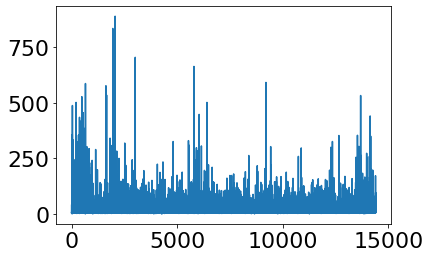

In [34]:
print("max: ",max(list(map(lambda comment: len(comment.split()),df.comment))))
print("min: ",min(list(map(lambda comment: len(comment.split()),df.comment))))
print("mean: ",statistics.mean(list(map(lambda comment: len(comment.split()),df.comment))))
plt.plot(df.comment.index,list(map(lambda comment: len(comment.split()),df.comment)))

In [35]:
sentences = df.comment.values
labels = df.toxic.values

In [36]:
X_train, X_test, y_train, y_test = train_test_split(sentences, labels, test_size=.2, random_state=42)

In [37]:
X_train.shape

(11529,)

[FastText Embedding by David Dale](https://github.com/avidale/compress-fasttext/releases/tag/v0.0.1)

In [38]:
import compress_fasttext
# url = 'https://github.com/avidale/compress-fasttext/releases/download/v0.0.1/ft_freqprune_100K_20K_pq_300.bin'

# print(small_model['спасибо'])
# # [ 0.26762889  0.35489027 ...  -0.06149674] # a 300-dimensional vector
# print(small_model.most_similar('котенок'))


# import fasttext
url = 'https://github.com/avidale/compress-fasttext/releases/download/v0.0.1/ft_freqprune_100K_20K_pq_300.bin'
PATH_FASTTEXT = 'ft_freqprune_100K_20K_pq_300.bin'



if not os.path.exists(PATH_FASTTEXT):
    wget.download(url)
    
# ft = fasttext.load_model('ft_freqprune_100K_20K_pq_300.bin')

ft = gensim.models.fasttext.FastTextKeyedVectors.load('ft_freqprune_100K_20K_pq_300.bin')
print(ft['jhsfbjhsg'].shape)


(300,)


In [39]:
PAD_TOKEN = '<pad>'

In [40]:
def vectorize_sentence(sentence: str, vectorizer=ft, pad_token = PAD_TOKEN, max_sequence_length=30) -> np.array:
    tokens = sentence.split()
    embedd_tokens = [vectorizer.get_vector(t) for t in tokens[:max_sequence_length]]
    if len(embedd_tokens) < max_sequence_length:
        embedd_tokens += [vectorizer[pad_token]] * (max_sequence_length - len(embedd_tokens))
    return np.array(embedd_tokens)

In [41]:
# получить длину(количество слов) отзывов в 75% датасета
sequence_length=int(round(np.percentile(list(map(lambda sentence: len(sentence.split()), X_train)), 75)))

In [42]:
sequence_length=32
sequence_length

32

# Word Vectorizer

In [43]:
X_train = np.array(list(map(
    lambda sentence:vectorize_sentence(
        sentence,
        vectorizer=ft,
        pad_token = PAD_TOKEN,
        max_sequence_length=sequence_length),
    X_train.flatten()
    )
))

X_test = np.array(list(map(
    lambda sentence:vectorize_sentence(
        sentence,
        vectorizer=ft,
        pad_token = PAD_TOKEN,
        max_sequence_length=sequence_length),
    X_test.flatten()
    )
))

# X_train = np.array(list(
#     map(fasttext_sentence_vectorizer, X_train.flatten())
# ))

# X_test = np.array(list(
#     map(fasttext_sentence_vectorizer, X_test.flatten())
# ))

In [44]:
X_train.shape

(11529, 32, 300)

In [45]:
ft[PAD_TOKEN].shape[0]

300

In [46]:
DIMENSION_EMBEDDING=ft[PAD_TOKEN].shape[0]

# Build model  BiLSTM

Model: "FASTTEXT-RusVectores_BiLSTM"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 spatial_dropout1d_1 (Spatia  (None, 32, 300)          0         
 lDropout1D)                                                     
                                                                 
 bidirectional_1 (Bidirectio  (None, 32, 512)          1140736   
 nal)                                                            
                                                                 
 global_max_pooling1d_1 (Glo  (None, 512)              0         
 balMaxPooling1D)                                                
                                                                 
 dropout_2 (Dropout)         (None, 512)               0         
                                                                 
 dense_2 (Dense)             (None, 64)                32832     
                                       

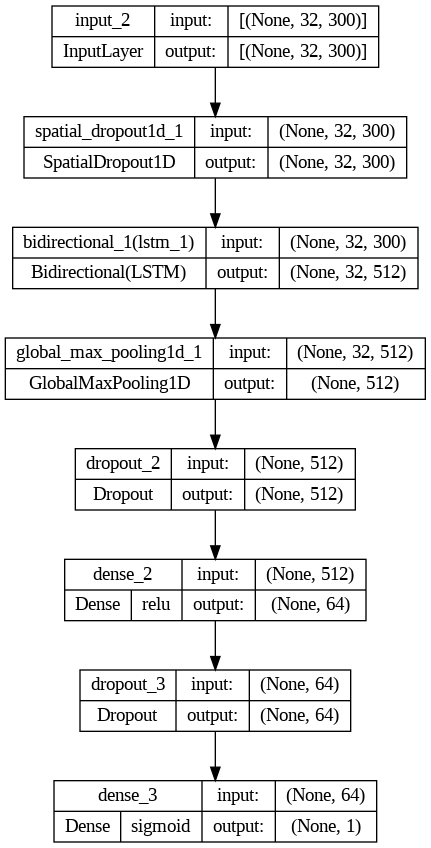

In [47]:
import tensorflow as tf
from tensorflow.keras.metrics import TruePositives,FalsePositives,TrueNegatives,FalseNegatives,BinaryAccuracy,Precision,Recall,AUC,AUC
from tensorflow.keras import Sequential,losses
from tensorflow.keras.layers import Input, Dense, Dropout,Bidirectional,LSTM,SpatialDropout1D,GlobalMaxPool1D
from tensorflow.keras.utils import plot_model

METRICS = [
      TruePositives(name='tp'),
      FalsePositives(name='fp'),
      TrueNegatives(name='tn'),
      FalseNegatives(name='fn'), 
      BinaryAccuracy(name='accuracy'),
      Precision(name='precision'),
      Recall(name='recall'),
      AUC(name='auc'),
      AUC(name='prc', curve='PR'), # precision-recall curve
]

MODEL_NAME = 'FASTTEXT-RusVectores_BiLSTM'
SEED = 42
SPLIT = 0.2
EPOCHS = 50
BATCH_SIZE = 512

negative_count, neutral_count = np.bincount(y_train)

initial_output_bias = tf.keras.initializers.Constant(
    np.log([neutral_count/negative_count])
)

model = tf.keras.Sequential(
    [
    Input(shape=(sequence_length, DIMENSION_EMBEDDING,),dtype=tf.float32),
    SpatialDropout1D(0.2),
    Bidirectional(LSTM(256, recurrent_dropout=0.1, return_sequences=True)),
    GlobalMaxPool1D(),
    Dropout(rate=0.5, seed=SEED),
    Dense(64, activation='relu'),
    Dropout(rate=0.5, seed=SEED),
    Dense(1,bias_initializer=initial_output_bias,activation='sigmoid'),
]
,name=MODEL_NAME)

model.compile(
    loss=losses.BinaryCrossentropy(from_logits=False),
    optimizer='adam',
    metrics=METRICS
)
model.summary()

plot_model(model,
           to_file='model.png',
           show_shapes=True,
           show_layer_names=True,
           layer_range=None,
            show_layer_activations=True)

In [48]:
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    mode='min',
    patience=5,
    verbose=1,
    restore_best_weights=True
)

def calculate_weights(pos_count, neg_count):
    total = pos_count + neg_count
    return {
        0: (1 / neg_count) * total / 2.0,
        1: (1 / pos_count) * total / 2.0
    }

history = model.fit(
    x=X_train,
    y=y_train,
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    validation_split=SPLIT,
    callbacks=[early_stopping],
    class_weight=calculate_weights(neutral_count, negative_count),
)

Epoch 1/50
19/19 [==============================] - 62s 3s/step - loss: 0.6234 - tp: 1987.0000 - fp: 2119.0000 - tn: 3968.0000 - fn: 1149.0000 - accuracy: 0.6457 - precision: 0.4839 - recall: 0.6336 - auc: 0.7058 - prc: 0.5513 - val_loss: 0.7545 - val_tp: 673.0000 - val_fp: 649.0000 - val_tn: 906.0000 - val_fn: 78.0000 - val_accuracy: 0.6847 - val_precision: 0.5091 - val_recall: 0.8961 - val_auc: 0.8611 - val_prc: 0.7461
Epoch 2/50
19/19 [==============================] - 55s 3s/step - loss: 0.4965 - tp: 2492.0000 - fp: 1469.0000 - tn: 4618.0000 - fn: 644.0000 - accuracy: 0.7709 - precision: 0.6291 - recall: 0.7946 - auc: 0.8437 - prc: 0.7002 - val_loss: 0.3957 - val_tp: 568.0000 - val_fp: 225.0000 - val_tn: 1330.0000 - val_fn: 183.0000 - val_accuracy: 0.8231 - val_precision: 0.7163 - val_recall: 0.7563 - val_auc: 0.8859 - val_prc: 0.7903
Epoch 3/50
19/19 [==============================] - 52s 3s/step - loss: 0.4289 - tp: 2548.0000 - fp: 1139.0000 - tn: 4948.0000 - fn: 588.0000 - accur

**Save Model**

In [49]:
model.save(MODEL_NAME)

In [50]:
pred = model.predict(X_test).flatten()

91/91 [==============================] - 13s 136ms/step


In [51]:
threshold =0.5
pred = np.where(pred<threshold,0,1)

**Model evaluation**

In [52]:
import seaborn as sns
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
from sklearn.metrics import ConfusionMatrixDisplay

def score_to_percent(score):
    return str(round(score * 100, 2)) + ' %'

def plot_cm(labels, predictions, p=0.5):
  cm = confusion_matrix(labels, predictions > p)
  plt.rcParams.update({'font.size': 22})
  plt.figure(figsize=(7,7))
  sns.heatmap(cm, annot=True, fmt="d",cmap='PuBu')
  plt.title('Confusion matrix @{:.2f}'.format(p))
  plt.ylabel('Actual label')
  plt.xlabel('Predicted label')
  print("Accuracy:", score_to_percent(accuracy_score(y_test, pred)))
  print("Recall:", score_to_percent(recall_score(y_test, pred)))
  print("Precision:",score_to_percent(precision_score(y_test, pred)))
  print("F1-score:", score_to_percent(f1_score(y_test, pred)), '\n')  
  print('True Negatives: ', cm[0][0])
  print('False Positives: ', cm[0][1])
  print('False Negatives: ', cm[1][0])
  print('True Positives: ', cm[1][1])

Accuracy: 88.62 %
Recall: 86.37 %
Precision: 80.22 %
F1-score: 83.18 % 

True Negatives:  1744
False Positives:  200
False Negatives:  128
True Positives:  811


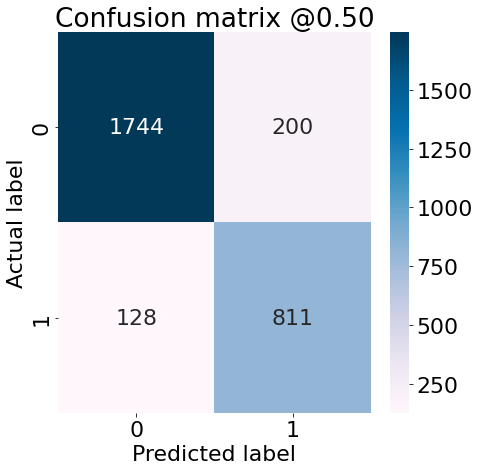

In [53]:
plot_cm(y_test, pred)

In [54]:
def plot_metrics(history):
  metrics = ['loss','accuracy', 'precision', 'recall','auc','prc']
  plt.figure(figsize=(20, 20), tight_layout={'h_pad': 3})
  for n, metric in enumerate(metrics):
    name = metric.replace("_"," ").capitalize()
    plt.subplot(3,2,n+1)
    plt.plot(history.epoch, history.history[metric],  label='Train')
    plt.plot(history.epoch, history.history['val_'+metric],label='Val')
    plt.xlabel('Epoch', fontdict={'fontsize': 15})
    plt.title(name, fontdict={'fontsize': 21, 'fontweight': 500}, pad=20)
    plt.legend(fontsize=21)
    if metric == 'loss':
      plt.ylim([0, plt.ylim()[1]])
    elif metric == 'auc':
      plt.ylim([0.8,1])
    else:
      plt.ylim([0,1])

    plt.legend();

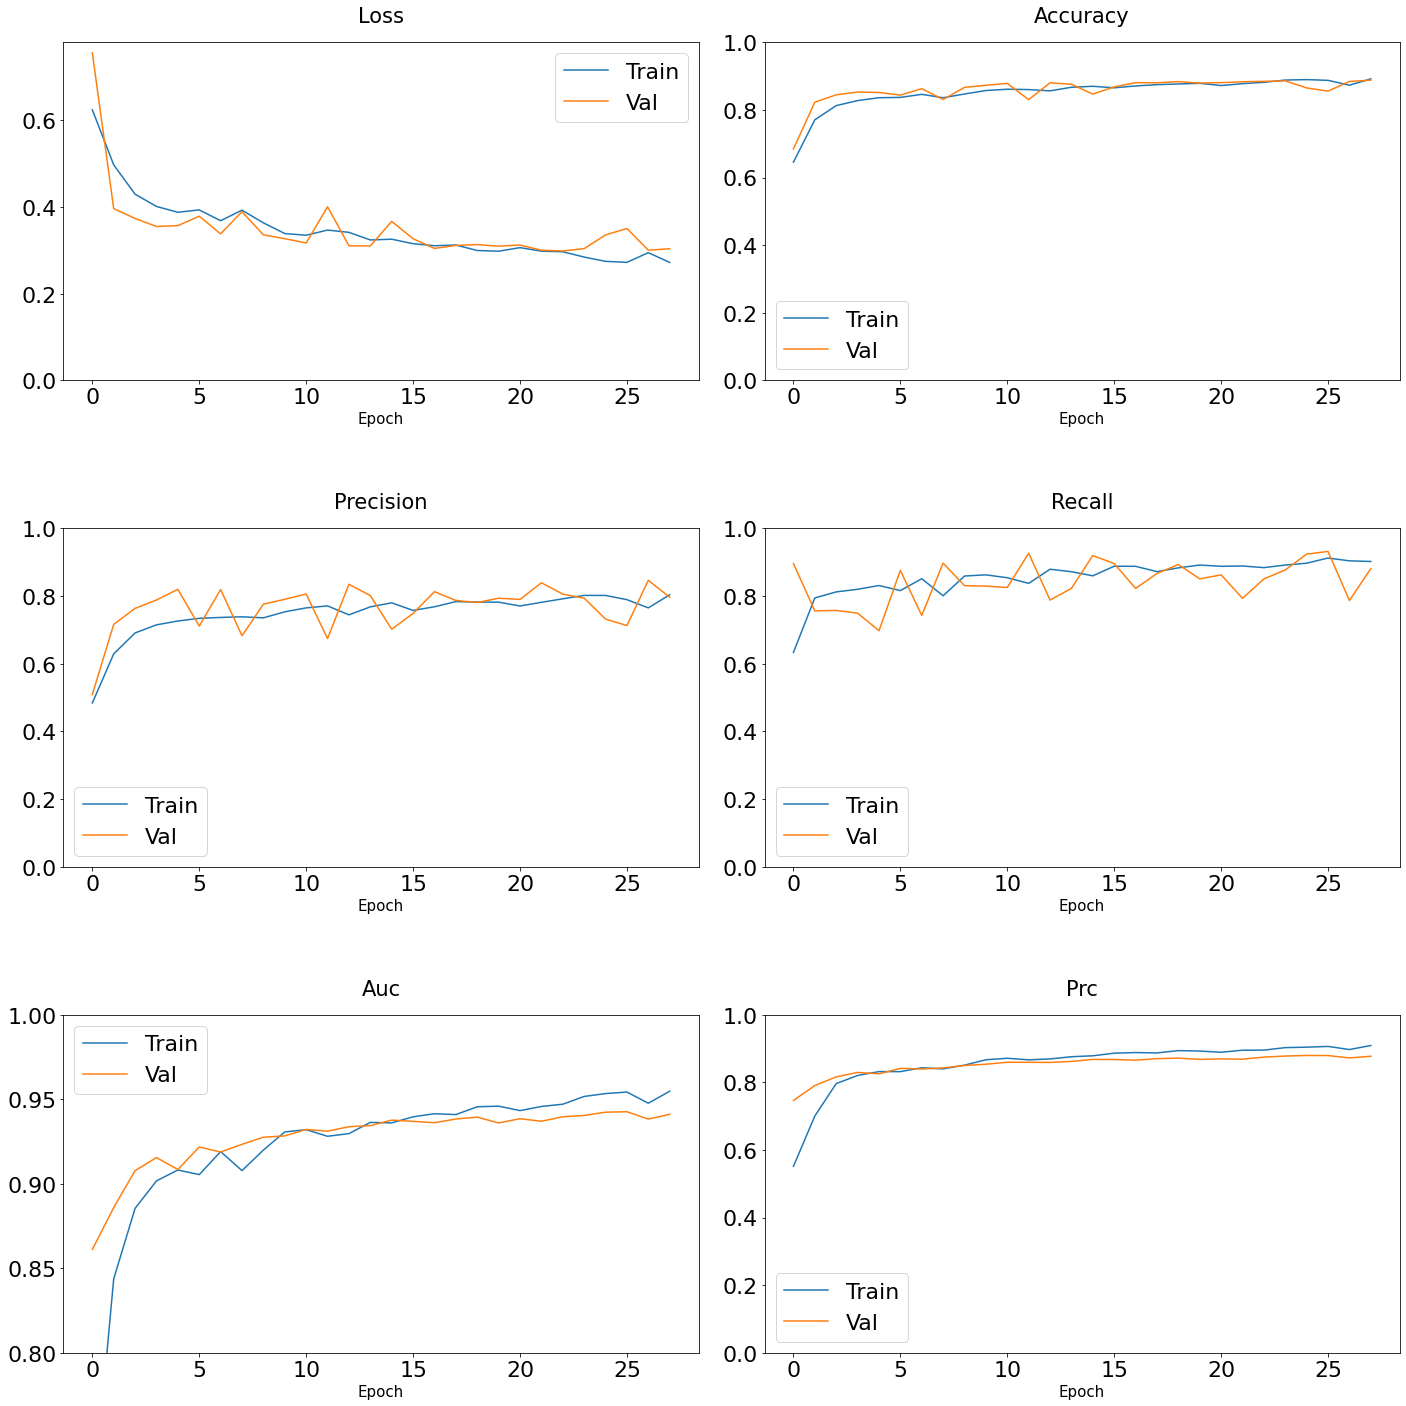

In [55]:
plot_metrics(history)

**Отобразим ROC - кривую**

91/91 [==============================] - 12s 136ms/step
: ROC AUC=0.947


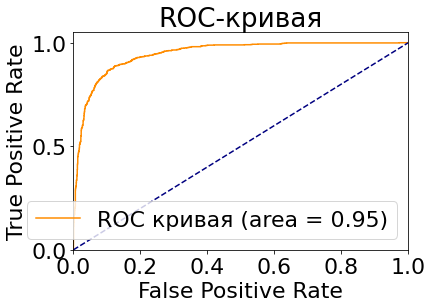

In [56]:
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import roc_auc_score
# сохраняем вероятности только для положительного исхода
lr_probs = model.predict(X_test).flatten()
threshold =0.5
pred = np.where(pred<threshold,0,1)
# рассчитываем ROC AUC
lr_auc = roc_auc_score(y_test, lr_probs)
print(': ROC AUC=%.3f' % (lr_auc))
# рассчитываем roc-кривую
fpr, tpr, treshold = roc_curve(y_test, lr_probs)
roc_auc = auc(fpr, tpr)
# строим график
plt.plot(fpr, tpr, color='darkorange',
         label='ROC кривая (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC-кривая')
plt.legend(loc="lower right")
plt.show()